<a href="https://colab.research.google.com/github/moosunny/Graph-Neural-Networks-Practice/blob/main/Chapter%207.%20Graph%20Attention%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7. Graph Attention Networks

### Introducing the graph attention layer

이전 chapter에서 소개된 GCN은 노드별로 보유한 이웃 노드의 개수를 고려하여 이웃 노드의 개수가 적은 노드의 경우 중요한 정보를 갖고 있음을 확인했다. 하지만, 노드의 차수(degree)만을 고려했다는 한계가 있었다.

Graph Attention Layer의 경우 가중된 요소인 각 노드 feature의 중요도를 고려한다. 하기 식은 가중치 요소라고 불리는 attention score를 계산하여 노드 $i$, $j$ 간의 attention score를 계산하는 식이다.

$$
h_i = \sum_{j \in N_i}{\alpha_{ij}Wx_j}
$$

### Linear Transformation

attention score는 중심이 되는 노드 $i$와 이웃 노드 $j$의 중요도를 나타낸다. 각 노드의 feature들이 필요하고 그래프 구조에서는 hidden 벡터들의 concat으로 표현된다. $[Wx_i \parallel Wx_j]$

${W}$는 전통적으로 활용되어왔던 가중치 행렬을 나타낸다. GAT의 특징은 learnerable parameter인 W_att 행렬을 통해서 추가적인 선형 변환이 요구된다. 모델의 학습 과정에서 $W_{att}$ 행렬은 지속적으로 업데이트되면서 행렬 $a_{ij}$ attention coefficient를 만든다.

$$
a_{ij} = W_{att}^T[W_{xi} \parallel W_{xj}]
$$

### Implementing the graph attention layer in Numpy

그래프 데이터 셋은 반드시 두 개의 요소가 필요하다.
1. self-loop를 포함한 인접행렬: $\tilde{A}$
2. node features: $X$

In [1]:
import numpy as np
np.random.seed(42)

# 인접행렬 생성, 노드: 4개, edge 개수: 8개(self-loop 포함)
A = np.array([
    [1, 1, 1, 1],
    [1, 1, 0, 0],
    [1, 0, 1, 1],
    [1, 0, 1, 1],
    ])

# 노드 feature 행렬 생성
X = np.random.uniform(-1,1, (4,4))
X

array([[-0.25091976,  0.90142861,  0.46398788,  0.19731697],
       [-0.68796272, -0.68801096, -0.88383278,  0.73235229],
       [ 0.20223002,  0.41614516, -0.95883101,  0.9398197 ],
       [ 0.66488528, -0.57532178, -0.63635007, -0.63319098]])

그래프 구조에서의 인접행렬과 node feature 행렬이 정의되었다면, 다음에는 가중치 행렬이 정의될 순서이다. GAT의 가중치 행렬에는 두가지 행렬이 있다.

1. $W_{att}$: attention weight matrix(Xabier or He initialization)
2. $W$: 일반적인 weight 행렬

$W$ 행렬의 차원($\text{nb of hidden dimensions, nb of nodes}$)은 임의로 (4,hidden dimension)로 정의되지만 이번 구현에서는 (4,2)로 임의 값을 hiddne vextor의 차원을 정의한다.

$W_{att}$의 차원은 (1, hidden vector의 차원 x 2) 로 정의된다. 따라서, hidden vector(2) x 2로 (1,4)의 차원을 갖는다.

In [70]:
W = np.random.uniform(-1,1,(2,4))
W_att = np.random.uniform(-1,1,(1,4))

print("가중치 행렬: \n",W)
print("W_att 행렬: \n",W_att)

가중치 행렬: 
 [[ 0.78409311  0.26227725  0.58962261  0.00527419]
 [ 0.15380777 -0.01496461 -0.60951402  0.44490423]]
W_att 행렬: 
 [[-0.43845528 -0.95136807  0.29094459 -0.64577864]]


가중치 행렬 정의 후에는 hidden vector들을 concat하여 source 노드와 target 노드 형태로 구성한다.

- 행: source node
- 열: target node

In [71]:
connections = np.where(A > 0)
connections

(array([0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 3]),
 array([0, 1, 2, 3, 0, 1, 0, 2, 3, 0, 2, 3]))

In [72]:
# hidden vector concatenate
np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis = 1)

array([[ 0.31429819, -0.24710291,  0.31429819, -0.24710291],
       [ 0.31429819, -0.24710291, -1.23714168,  0.76901691],
       [ 0.31429819, -0.24710291, -0.29267908,  1.02742781],
       [ 0.31429819, -0.24710291, -0.0081078 ,  0.21702893],
       [-1.23714168,  0.76901691,  0.31429819, -0.24710291],
       [-1.23714168,  0.76901691, -1.23714168,  0.76901691],
       [-0.29267908,  1.02742781,  0.31429819, -0.24710291],
       [-0.29267908,  1.02742781, -0.29267908,  1.02742781],
       [-0.29267908,  1.02742781, -0.0081078 ,  0.21702893],
       [-0.0081078 ,  0.21702893,  0.31429819, -0.24710291],
       [-0.0081078 ,  0.21702893, -0.29267908,  1.02742781],
       [-0.0081078 ,  0.21702893, -0.0081078 ,  0.21702893]])

In [73]:
# Linear Trnasformation
# attention weight matrix @ hidden vector with concatenate
a = W_att @ np.concatenate([(X @ W.T)[connections[0]], (X @ W.T)[connections[1]]], axis = 1).T
a

array([[ 0.34829725, -0.75927426, -0.65136422, -0.04523146,  0.0618303 ,
        -1.04574121, -0.59811818, -1.59777965, -0.99164689,  0.04809765,
        -0.95156382, -0.34543106]])

### Activation Function



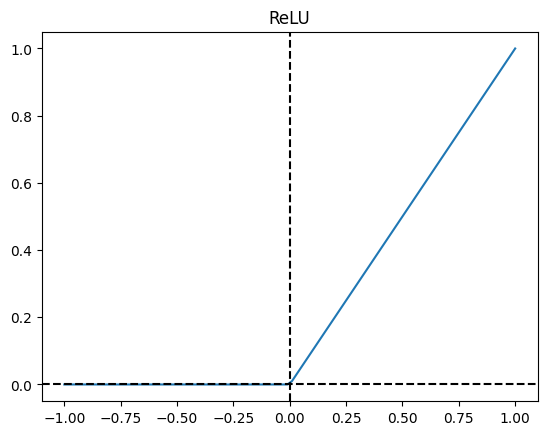

In [74]:
x = np.linspace(-1,1,100)
plt.title("ReLU")
plt.plot(x, np.maximum(x, np.zeros(100)))
plt.axvline(x=0, ls = '--', color='black')
plt.axhline(y=0, ls = '--', color='black')
plt.show()

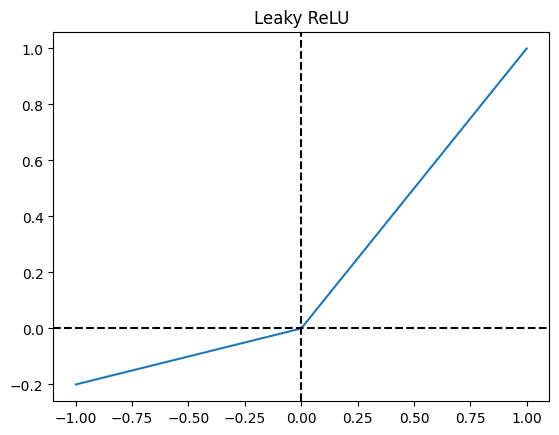

In [75]:
import matplotlib.pyplot as plt

x = np.linspace(-1,1,100)
y = 0.2*x
plt.title("Leaky ReLU")
plt.plot(x, np.maximum(0.2*x, x))
plt.axvline(x=0, ls = '--', color='black')
plt.axhline(y=0, ls = '--', color='black')
plt.show()

In [76]:
def leaky_relu(x, alpha):
  return np.maximum(alpha*x, x)

e = leaky_relu(a, 0.2)
e

array([[ 0.34829725, -0.15185485, -0.13027284, -0.00904629,  0.0618303 ,
        -0.20914824, -0.11962364, -0.31955593, -0.19832938,  0.04809765,
        -0.19031276, -0.06908621]])

In [77]:
E = np.zeros(A.shape)
E[connections[0], connections[1]] = e[0] # 인덱싱 E[source node, target node]
E # self-loop를 포함한 인접행렬과 동일한 형태를 띄도록 한다.

array([[ 0.34829725, -0.15185485, -0.13027284, -0.00904629],
       [ 0.0618303 , -0.20914824,  0.        ,  0.        ],
       [-0.11962364,  0.        , -0.31955593, -0.19832938],
       [ 0.04809765,  0.        , -0.19031276, -0.06908621]])

### Softmax normalization

In [50]:
# attention score 정규활를 위한 softmax 함수 활용
def softmax2D(x, axis):
  e = np.exp(x - np.max(x, axis=axis, keepdims=True))
  s = np.sum(e, axis=axis, keepdims=True)
  return e / s

W_alpha = softmax2D(E,1)
W_alpha

array([[0.26139114, 0.20296726, 0.32394076, 0.21170085],
       [0.34970573, 0.27154254, 0.18937587, 0.18937587],
       [0.29540969, 0.09923804, 0.36609978, 0.23925249],
       [0.24003878, 0.23569378, 0.29747888, 0.22678855]])


### Graph Attention Layer
$$
H = \tilde{A^T}W_a X W^T
$$

In [51]:
H = A.T @ W_alpha @ X @ W.T
H

array([[-1.21585747,  2.880156  ],
       [-0.53288248,  1.47336126],
       [-1.00094156,  2.17716021],
       [-1.00094156,  2.17716021]])